In [13]:
# Add output lines wrapping
from IPython.display import HTML, display
def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [1]:
#Initial Loading
from google.colab import drive
drive.mount('/content/drive')

# IMPORTANT to make it work you need to right click the AIR folder that Ben shared with you, choose "make shortcut" and make it in your main drive folder
%cd '/content/drive/MyDrive/AIR'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1zgquUstuGcUbKxKaHNRv1i81-8NcnY2Y/AIR


In [ ]:
# Ben's cd LUKASZ: I will comment it for now so it works for others
# %cd '/content/drive/MyDrive/Uni/AIR'

/content/drive/MyDrive/Uni/AIR


In [ ]:
# Colab may ask you to restart runtime - do this once only, then rerun the previous cell again (up to your relevant cd)
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 505 kB 5.2 MB/s 
     |████████████████████████████████| 29.1 MB 1.6 MB/s 
     |████████████████████████████████| 636 kB 75.7 MB/s 
     |████████████████████████████████| 748.8 MB 18 kB/s 
     |████████████████████████████████| 1.3 MB 49.3 MB/s 
     |████████████████████████████████| 125 kB 42.0 MB/s 
     |████████████████████████████████| 132 kB 66.9 MB/s 
     |████████████████████████████████| 592 kB 58.7 MB/s 
     |████████████████████████████████| 880 kB 41.9 MB/s 
     |████████████████████████████████| 2.9 MB 40.3 MB/s 
     |████████████████████████████████| 1.1 MB 59.3 MB/s 
     |████████████████████████████████| 79 kB 6.9 MB/s 
     |████████████████████████████████| 8.8 MB 40.6 MB/s 
     |████████████████████████████████| 138 kB 72.7 MB/s 
     |████████████████████████████████| 127 kB 75.1 MB/s 
  Created wheel for overrides: fil

In [2]:
# fetch judgement_aggregation script - you have to run it before using it
!rm -rf TextProcessing
!git clone https://github.com/Fidelisus/TextProcessing.git
# del JudgementAggregation

from TextProcessing.src.judgement_aggregation import JudgementAggregation

Cloning into 'TextProcessing'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 30 (delta 12), reused 27 (delta 9), pack-reused 0
Unpacking objects: 100% (30/30), done.


# Judgement aggregation
## 1. Imports

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from operator import itemgetter

## 2. Load the data
### Part 1

There were 3 tables that I needed to merge in order to create a dataset that you will be able (hopefully) to use without problems with modelling. I described what I found in each table in comments in the code.

Format that they use:
https://trec.nist.gov/data/qrels_eng/

The output of my data loading is of a similar form for every part. Why? Because this is the standardized approach that was also used by them in the "baseline" table. So, the output is a Dataframe, where each row corresponds to a query -> document pair evaluated by the user (so basically what we did for the first assignment). Fields that the output table in every part has:
- queryId - id of a query
- documentId - id of a document returned by the query by the user
- relevanceLevel - relevance score given to query>document pair by a particular user: 0, 1, 2 or 3 . Long names for these numbers: "0_NOT_RELEVANT", "1_TOPIC_RELEVANT_DOES_NOT_ANSWER", "2_GOOD_ANSWER", "3_PERFECT_ANSWER"
- queryIteration - not used by any of the parts, I added it for the sake of completeness, so that it is the same as the baseline. Imo, it can be dropped later
- documentText - text of the document
- queryText - text of the query
- other fields that provide additional info, different for each part

In [4]:
# loading of part 1 data
main_folder = "data/Part-1/"

# paths to relevant datasets
config_p1 = {
    "baseline": main_folder + "fira-22.baseline-qrels.tsv",
    "docs": main_folder + "fira-22.documents.tsv",
    "judgements": main_folder + "fira-22.judgements-anonymized.tsv",
    "queries": main_folder + "fira-22.queries.tsv",
}

# Their outcome of doing judgement aggregation
# I load it to see how it looks and also recreate it to ensure that I understand it right
baseline = pd.read_csv(config_p1["baseline"],sep=' ', header=None)
baseline.columns = ["queryId", "queryIteration", "documentId", "relevanceLevel"]

# Document text with id
documents = pd.read_csv(config_p1["docs"],sep='\t', header= 0, names= ["documentId", "documentText"], index_col="documentId")
# relevance score given to query>document pair by a particular user and some additional info
judgements_p1 = pd.read_csv(config_p1["judgements"], sep='\t')
# Query text with id
queries = pd.read_csv(config_p1["queries"],sep='\t', header= 0, names= ["queryId", "queryText"], index_col="queryId")

judgements_p1 = judgements_p1.join(documents, how="inner", on="documentId").join(queries, how="inner", on="queryId")
judgements_p1["queryIteration"] = 0
display(judgements_p1.head())

# transform relevanceLevels to int
judgements_p1["relevanceLevel"] = judgements_p1["relevanceLevel"].replace(
    ["0_NOT_RELEVANT", "1_TOPIC_RELEVANT_DOES_NOT_ANSWER", "2_GOOD_ANSWER", "3_PERFECT_ANSWER"], [0, 1, 2, 3])


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
0,1,2_GOOD_ANSWER,<no ranges selected>,15712,1648481149,rob_FBIS3-10909,rob_q_FBIS3-10909,User_0,chile manuel rodriguez front regional leader a...,manuel rodriguez chile,0
999,1003,2_GOOD_ANSWER,<no ranges selected>,19136,1648501459,rob_FBIS3-10909,rob_q_FBIS3-10909,User_4,chile manuel rodriguez front regional leader a...,manuel rodriguez chile,0
1993,2003,3_PERFECT_ANSWER,<no ranges selected>,5815,1648554616,rob_FBIS3-10909,rob_q_FBIS3-10909,User_19,chile manuel rodriguez front regional leader a...,manuel rodriguez chile,0
3160,3170,3_PERFECT_ANSWER,209-301,50368,1648576866,rob_FBIS4-33225,rob_q_FBIS3-10909,User_49,""""""""""""""" """""""" """""""" daily report chile leftist m...",manuel rodriguez chile,0
4160,4170,0_NOT_RELEVANT,<no ranges selected>,6354,1648627791,rob_FBIS4-33225,rob_q_FBIS3-10909,User_62,""""""""""""""" """""""" """""""" daily report chile leftist m...",manuel rodriguez chile,0


### Part 2
I did almost the same as in Part 1, the difference is that they already split the data into train and validation sets. I didn't know what to do with some files, maybe they are just useless?

In [ ]:
# loading of part 2 data
main_folder = "data/Part-2/"

# paths to relevant datasets
config_p2 = {
    "train_data": main_folder + "triples.train.tsv",
    "tuples_validation": main_folder + "msmarco_tuples.validation.tsv",
    "queries_validation": main_folder + "msmarco_queries.validation.tsv",
    "tuples_test": main_folder + "msmarco_tuples.test.tsv",
    "queries_test": main_folder + "msmarco_queries.test.tsv",
    "qrels": main_folder + "msmarco_qrels.txt",
    
}

# This one is a mistery to me, I don't know how can we use it.
# But they don't mention it in the exercise, so maybe we don't need it
tuples_train_p2 = pd.read_table(config_p2["train_data"], header=None, nrows=1000)
display(tuples_train_p2.head())

# msmarco_queries.validation.tsv - I think that this file are just queries extracted from msmarco_tuples.validation.tsv
# so nothing interesting for us
# Same about msmarco_queries.test.tsv

# msmarco_qrels.txt - here we have relevance levels for each queryId, documentId pair
qrels_p2 = pd.read_table(config_p2["qrels"], header=None, names=["queryId", "queryIteration", "documentId", "relevanceLevel"])
display(qrels_p2.head())
print(qrels_p2.shape)

# msmarco_tuples.test.tsv - it contains "queryText" ,"documentText" for each queryId, documentId pair. It should be used for testing
test_tuples_p2 = pd.read_table(config_p2["tuples_test"], header=None, names=["queryId", "documentId", "queryText" ,"documentText"])
display(test_tuples_p2.head())

# msmarco_tuples.validation.tsv - it contains "queryText" ,"documentText" for each queryId, documentId pair. It should be used for validation
validation_tuples_p2 = pd.read_table(config_p2["tuples_validation"], header=None, names=["queryId", "documentId", "queryText" ,"documentText"])
display(validation_tuples_p2.head())

# Validation and test sets merge to the standard format
test_judgements_p2 = pd.merge(test_tuples_p2, qrels_p2, how="inner", on=["documentId", "queryId"])
display(test_judgements_p2.head())
print(test_judgements_p2.shape)

validation_judgements_p2 = pd.merge(validation_tuples_p2, qrels_p2, how="inner", on=["documentId", "queryId"])
display(validation_judgements_p2.head())
print(validation_judgements_p2.shape)

,0,1,2
0,is a little caffeine ok during pregnancy,We donât know a lot about the effects of caf...,It is generally safe for pregnant women to eat...
1,what fruit is native to australia,Passiflora herbertiana . A rare passion fruit ...,"The kola nut is the fruit of the kola tree , a..."
2,how large is the canadian military,The Canadian Armed Forces . 1 The first large ...,The Canadian Physician Health Institute ( CPHI...
3,types of fruit trees,Cherry . Cherry trees are found throughout the...,"The kola nut is the fruit of the kola tree , a..."
4,how many calories a day are lost breastfeeding,Not only is breastfeeding better for the baby ...,"However , you still need some niacin each day ..."


,queryId,queryIteration,documentId,relevanceLevel
0,1102432,0,2026790,1
1,1102431,0,7066866,1
2,1102431,0,7066867,1
3,1090282,0,7066900,1
4,39449,0,7066905,1


(59273, 4)


,queryId,documentId,queryText,documentText
0,6791,7660585,What Does Noel Mean in the Bible,Period extending from Dec. 24 to Jan. 6.What t...
1,6791,1971025,What Does Noel Mean in the Bible,It's the old form if christmas and it also mea...
2,6791,4994790,What Does Noel Mean in the Bible,EMILY. Incoming search terms: biblical meaning...
3,6791,5205054,What Does Noel Mean in the Bible,Incoming search terms: biblical meaning of the...
4,6791,6074419,What Does Noel Mean in the Bible,MELISSA. Incoming search terms: biblical meani...


,queryId,documentId,queryText,documentText
0,2,1782337,Androgen receptor define,Enzalutamide is an androgen receptor inhibitor...
1,2,1001873,Androgen receptor define,The AR gene provides instructions for making a...
2,2,3634076,Androgen receptor define,SARMS or Selective Androgen Receptor Modulator...
3,2,4339075,Androgen receptor define,"During androgen-independent progression, prost..."
4,2,6285817,Androgen receptor define,The term SARMS stands for “Selective Androgen ...


,queryId,documentId,queryText,documentText,queryIteration,relevanceLevel
0,8701,7990420,_____ is the ability of cardiac pacemaker cell...,A skeletal muscle contracts only after it is s...,0,1
1,10264,7791854,access parallels cost,"That's a nice improvement, but not one that's ...",0,1
2,36473,7366036,average fifty year old retirement savings,"Using these guidelines, Cathey suggests the fo...",0,1
3,36703,7996780,average gas prices in ga,"Atlanta, GA Lowest Regular Gas Prices Summary....",0,1
4,36965,7314108,average heavy equipment mechanic salary,Heavy Equipment Mechanic average salary is $34...,0,1


(1248, 6)


,queryId,documentId,queryText,documentText,queryIteration,relevanceLevel
0,2,4339068,Androgen receptor define,"The androgen receptor (AR), also known as NR3C...",0,1
1,1215,7395960,3 levels of government in canada and their res...,"In Canada, there are 3 levels of government. E...",0,1
2,1288,7473138,3/5 of 60,3/5 = 60/1 3*60 = 5*1 180/5 = 36*1 answer = 36.,0,1
3,2235,7609417,Bethel University was founded in what year,Bethel University is a private institution tha...,0,1
4,2798,7800991,Does Suddenlink Carry ESPN3,"Earlier this month, Suddenlink and ESPN parent...",0,1


(1213, 6)


There are two issues that I encountered:
- when I joined qrels with tuples tables, most of the pair don't have join parter
- in qrels, which contains users scores, relevanceLevel is always 1

Tbh, I don't know what to do about it...

Also, there is only one score for each queryId>documentId pair so we don't have to do judgement aggregation.

In [ ]:
# see what would happen if I did outer join
outer_join_p2 = pd.merge(validation_tuples_p2, qrels_p2, how="outer", on=["documentId", "queryId"])
display(outer_join_p2.head())
print(outer_join_p2.shape)

# check why there are no join partners for queryId==2.
# It just turns out that only one queryId>documentId pair matches...
display(qrels_p2[qrels_p2["queryId"] == 2])
validation_judgements_p2[validation_judgements_p2["queryId"] == 2]

,queryId,documentId,queryText,documentText,queryIteration,relevanceLevel
0,2,1782337,Androgen receptor define,Enzalutamide is an androgen receptor inhibitor...,NaN,NaN
1,2,1001873,Androgen receptor define,The AR gene provides instructions for making a...,NaN,NaN
2,2,3634076,Androgen receptor define,SARMS or Selective Androgen Receptor Modulator...,NaN,NaN
3,2,4339075,Androgen receptor define,"During androgen-independent progression, prost...",NaN,NaN
4,2,6285817,Androgen receptor define,The term SARMS stands for “Selective Androgen ...,NaN,NaN


(138060, 6)


,queryId,queryIteration,documentId,relevanceLevel
27735,2,0,4339068,1


,queryId,documentId,queryText,documentText,queryIteration,relevanceLevel
0,2,4339068,Androgen receptor define,"The androgen receptor (AR), also known as NR3C...",0,1


In [ ]:
# check how many scores there are for each queryId>documentId pair
print(validation_judgements_p2.groupby(["queryId", "documentId"])["relevanceLevel"].value_counts().unique())

# check how many different relevance levels there are
qrels_p2["relevanceLevel"].unique()

[1]


array([1])

### Part 3
Here I found a problem due to Colab pandas version - my code for extracting multiple fields doesn't work. That's why, only first textSelection is available in the dataframe. However, hopefuly you won't need these selections, if yes, then I will implement it, so that it works on Collab.

In [ ]:
# loading of part 3 data
main_folder = "data/Part-3/"

# paths to relevant datasets
config_p3 = {
    "tuples": main_folder + "msmarco-fira-21.qrels.qa-tuples.tsv",
    "answers": main_folder + "msmarco-fira-21.qrels.qa-answers.tsv",
    "retrieval": main_folder + "msmarco-fira-21.qrels.retrieval.tsv",
}

def condense_text_selections(columns):
    text_selection_one_string = "\t".join([str(text_selection) for text_selection in columns[6:]])
    columns = columns[0:6]
    columns.append(text_selection_one_string)
    return columns

# It contains queryid, documentid,
# relevanceGrade (no idea what relevanceGrade but it is sth different than relevanceLevel) and
# textSelections (in this column there where multiple answers possible,
# they are in the textSelections string split with tab)
tuples_p3 = pd.read_table(config_p3["tuples"],
                                header=None,
                                # on_bad_lines=condense_text_selections,
                                names=[
                                "queryId", "documentId", "relevanceGrade",
                                "queryText" ,"documentText", "empty", "textSelections",
                                ],
                                # engine='python'
                          ).drop("empty", axis=1)

display(tuples_p3.head())
print(tuples_p3.shape)
print("Example of textSelections: ")
print(tuples_p3.iloc[4]["textSelections"])

# This dataframe is the same as judgements_p2 but with less columns. But they mentioned it so I also loaded it for you
answers_p3 = pd.read_table(config_p3["answers"], header=None, # on_bad_lines=condense_text_selections,
                           names=[
                               "queryId", "documentId", "relevanceGrade", "empty", "textSelections",
                           ], # engine='python'
                          ).drop("empty", axis=1)

display(answers_p3.head())
print(answers_p3.shape)
print("Example of textSelections: ")
print(answers_p3.iloc[4]["textSelections"])

#  here we have relevance levels for each queryId, documentId pair
retrieval_p3 = pd.read_csv(config_p3["retrieval"], header=None, sep=" ",
                           names=[
                               "queryId", "queryIteration", "documentId", "relevanceLevel",
                           ])

display(retrieval_p3.head())
print(retrieval_p3.shape)

judgements_p3 = pd.merge(tuples_p3, retrieval_p3, how="inner", on=["documentId", "queryId"]).drop("relevanceGrade", axis=1)
display(judgements_p3.head())

,queryId,documentId,relevanceGrade,queryText,documentText,textSelections
0,135386,100163,3,definition of imagination,imagination - the formation of a mental image ...,the formation of a mental image of something t...
1,290779,101026,3,how many oscars has clint eastwood won?pdrijgh...,Clint Eastwood -- five-time Oscar winner and e...,five
2,21741,1021598,3,are cold sores and fever blisters the same,"Cold sores, sometimes called fever blisters, a...","Cold sores, sometimes called fever blisters"
3,810210,1029662,3,what is the cause of blood in the stool,Having blood in the stool can be the result of...,"wide variety of conditions, such as hemorrhoid..."
4,1097448,103635,3,how many calories in slim fast shakes,"The chocolate-flavored shake contains 190, whi...",chocolate-flavored shake contains 190


(52606, 6)
Example of textSelections: 
chocolate-flavored shake contains 190


,queryId,documentId,relevanceGrade,textSelections
0,135386,100163,3,the formation of a mental image of something t...
1,290779,101026,3,five
2,21741,1021598,3,"Cold sores, sometimes called fever blisters"
3,810210,1029662,3,"wide variety of conditions, such as hemorrhoid..."
4,1097448,103635,3,chocolate-flavored shake contains 190


(52606, 4)
Example of textSelections: 
chocolate-flavored shake contains 190


,queryId,queryIteration,documentId,relevanceLevel
0,135386,0,100163,3
1,290779,0,101026,3
2,21741,0,1021598,3
3,239189,0,1027763,1
4,810210,0,1029662,3


(84731, 4)


,queryId,documentId,queryText,documentText,textSelections,queryIteration,relevanceLevel
0,135386,100163,definition of imagination,imagination - the formation of a mental image ...,the formation of a mental image of something t...,0,3
1,290779,101026,how many oscars has clint eastwood won?pdrijgh...,Clint Eastwood -- five-time Oscar winner and e...,five,0,3
2,21741,1021598,are cold sores and fever blisters the same,"Cold sores, sometimes called fever blisters, a...","Cold sores, sometimes called fever blisters",0,3
3,810210,1029662,what is the cause of blood in the stool,Having blood in the stool can be the result of...,"wide variety of conditions, such as hemorrhoid...",0,3
4,1097448,103635,how many calories in slim fast shakes,"The chocolate-flavored shake contains 190, whi...",chocolate-flavored shake contains 190,0,3


There are only 2 relevanceLevels - 2 and 3

Also, there is only one score for each queryId>documentId pair so we don't have to do judgement aggregation.

[1]
[3 2]


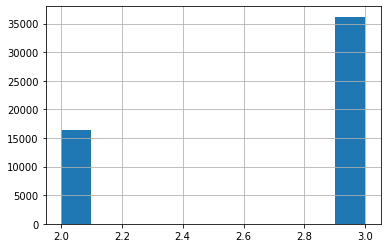

In [ ]:
print(judgements_p3.groupby(["queryId", "documentId"])["relevanceLevel"].value_counts().unique())

judgements_p3["relevanceLevel"].hist()

# Check possible relevance levels
print(judgements_p3["relevanceLevel"].unique())

### Data exploration of part 1
I do it only here in more details, as we need to provide judgement aggregation for it

Histogram of relevanceLevel variable

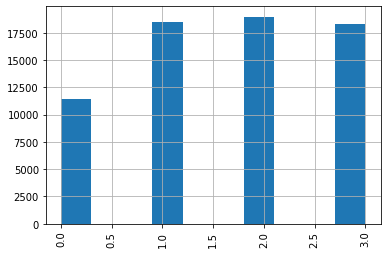

In [ ]:
judgements_p1["relevanceLevel"].hist(xrot=90)

Check if <document, query> pairs are unique. It turns out that multiple different queries can be assigned to one document and multiple different documents may be assigned to the same query. We can see it at the example dataframe below.

In [ ]:
print(judgements_p1.groupby("documentId")["queryId"].nunique().unique())

print(judgements_p1.groupby("queryId")["documentId"].nunique().unique())

# display an example of set of documents assigned to same query
display(judgements_p1[judgements_p1["queryId"] == "trip_9999"].sort_values("documentId").head())

print(judgements_p1[judgements_p1["documentId"] == "rob_FBIS3-10909"]["relevanceLevel"])

# Check possible relevance levels
print(judgements_p1["relevanceLevel"].unique())

[ 1  2  5  4  3 16 11  7 12  6  8  9 36 20 13 10 14 15 27 23]
[ 3  2  1 13 14 15 12 10 11  9  7  8]


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
63650,64009,2,<no ranges selected>,160000,1649699716,trip_10382921,trip_9999,User_9,coping styles used by sexual minority men who ...,intimate partner violence,0
66527,66946,3,<no ranges selected>,13038,1649712143,trip_10382921,trip_9999,User_148,coping styles used by sexual minority men who ...,intimate partner violence,0
36873,37006,1,<no ranges selected>,112851,1649327644,trip_11068256,trip_9999,User_13,intimate partner violence during pregnancy and...,intimate partner violence,0
39976,40112,2,1741-2702,158420,1649368209,trip_11068256,trip_9999,User_36,intimate partner violence during pregnancy and...,intimate partner violence,0
43060,43218,2,<no ranges selected>,38249,1649431396,trip_11068256,trip_9999,User_44,intimate partner violence during pregnancy and...,intimate partner violence,0


0       2
999     2
1993    3
Name: relevanceLevel, dtype: int64
[2 3 0 1]


Explore interesting property that many durationUsedToJudgeMs are 160000. Maybe that's like the maximal time recorded by the application and everything above it is cut down to 160000?

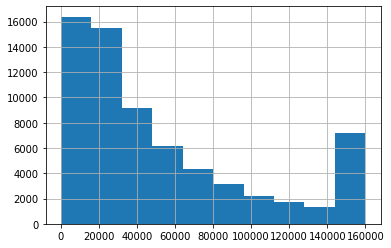

In [ ]:
judgements_p1["durationUsedToJudgeMs"].hist()

There are many judgememnts that were made faster than in 2 seconds. In our opinion, those should be dropped, as those users didn't think about their decision at all (mean judgement time is 53 sec).

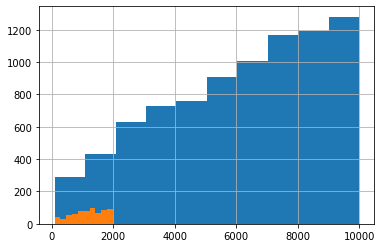

In [ ]:
judgements_p1[judgements_p1["durationUsedToJudgeMs"] < 10000]["durationUsedToJudgeMs"].hist()

53160.627945376655

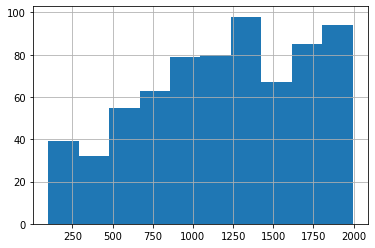

In [ ]:
judgements_p1[judgements_p1["durationUsedToJudgeMs"] < 2000]["durationUsedToJudgeMs"].hist()

judgements_p1["durationUsedToJudgeMs"].mean()

There are no users with some extensive amount of rated documents:

442.2631578947368
1372


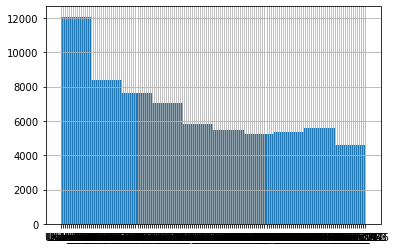

In [ ]:
print(judgements_p1["userId"].value_counts().mean())
print(judgements_p1["userId"].value_counts().max())

judgements_p1["userId"].hist()

How many scores has each pair. Interesting fact: it is maximum of 3, so we should take it into account while designing our judgement aggregation.

[3 2 1]


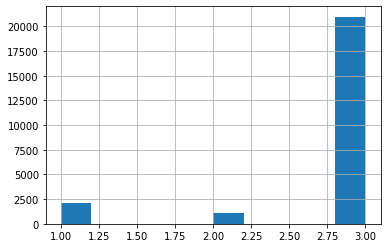

In [ ]:
print(judgements_p1.groupby("queryId")["documentId"].value_counts().unique())
judgements_p1.groupby("queryId")["documentId"].value_counts().hist()

### Transform relevance levels to match the baseline (to try out if I am correct)

In [ ]:
def unify_relevance_levels(levels):
    levels["relevanceLevel"] = levels["relevanceLevel"].mode().sort_values().iloc[-1]
    
    levels["queryIteration"] = "Q0"
    return levels

judgements_p1_transformed = judgements_p1.groupby(["queryId", "documentId"]).apply(
    unify_relevance_levels).reset_index().drop(["id"], axis = 1
)

df = pd.merge(judgements_p1_transformed, baseline, on=["queryId", "queryIteration", "documentId"], how='outer')
# Should display empty dataframe if i am correct
display(df[df["relevanceLevel_y"] != df["relevanceLevel_x"]])

,index,relevanceLevel_x,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration,relevanceLevel_y


### Implement our algorithm for judgement aggregation

First of all, we clean the data from aggregations made faster than 2 seconds. We split out aggregation into two steps:

1. Calculate user trust
For each user, we calculate how many times they agreed with other users while voting on the same pair. Then we normalize it by the total number of votes where they didn't vote alone.

It allowed us to give each user a score, of how much they agree with others in their grades. In our opinion, it is a way how to quantify how trustworthy is a user.

2. Aggregate
- We used rules to filter out cases where user scores were so different that we don't trust them.
- In order to calculate the final score, we used an average weighted by user trust scores. Because we want to make scores done by trustworthy users more important.
- Exact rules are commented on in the code. Also, there are # that point to the next cell, where there are examples of each rule in action

3. Result
Our approach ended up filtering 5.5% of most "tricky" examples.

4. Other approaches that failed:

- We wanted to use statistical tests test if scores come from this distribution.
- also wanted to use std of scores but for for max 3 scores it isn't meaningful.
- fleiss_kappa is not suitable.

In [5]:
# count of the times that user agreed on the score with someone else
users_trust = {}
# count of the times that user annotated, given there was also someone else annotating
# it will be used to normalize users_trust
users_annotations_count = {}

def calculate_user_trust(levels):
    def increment_or_create_user_count(key, dictionary, value=1):
        if key in dictionary:
            dictionary[key] += value
        else:
            dictionary[key] = value
        
    if levels.shape[0] == 1:
        return None

    users = levels[["userId", "relevanceLevel"]].set_index('userId').T.to_dict('list')
    
    for user in users.keys():
        increment_or_create_user_count(user, users_annotations_count)
        
        users_that_agree = 0
        for relevance in users.values():
            # we count number of the times that user agreed on the score with someone else
            # it means that if 3 users agreed on the grade, each of them gets 2 points
            if relevance == users[user]:
                users_that_agree += 1
        increment_or_create_user_count(user, users_trust, users_that_agree-1)

# Filter judgements 
judgements_p1_filtered = judgements_p1[judgements_p1["durationUsedToJudgeMs"] >= 2000]

judgements_p1_filtered.groupby(["queryId", "documentId"]).apply(calculate_user_trust)

# normalize user_trust by number of annotations of each user
# the normalized value can be bigger than 1, as we count each time a user agrees with other
# so i.e. if 3 users agreed on the grade, each of them gets 2 points
std = np.std(list(users_trust.values()))
users_trust_normalized = {k: v / users_annotations_count[k] for k, v in users_trust.items()}

In [6]:
def unify_relevance_levels(df):
    def get_max_distance_between_relevances(relevances):

        sorted_relevances = sorted(relevances)
        return sorted_relevances[-1] - sorted_relevances[0]
        
    # 0) When only 1 user rates
    if df.shape[0] == 1:
        return df
    
    user_relevance_dict = df[["userId", "relevanceLevel"]].set_index('userId').T.to_dict('list')
    
    # get relevances from the dictionary
    relevances = [item for sublist in list(user_relevance_dict.values()) for item in sublist]
    max_distance_between_relevances = get_max_distance_between_relevances(relevances)
    
    users = list(user_relevance_dict.keys())
    # 1) If there are only two scores and they are close to each other
    if df.shape[0] == 2 and max_distance_between_relevances <= 1.0:
        # a) if users agree
        if user_relevance_dict[users[0]] == user_relevance_dict[users[1]]:
            df["relevanceLevel"] = user_relevance_dict[users[0]][0]
            return df.iloc[[0]]
        # b if users disagree then we trust one with higher users_trust_normalized
        elif users_trust_normalized[users[0]] >= users_trust_normalized[users[1]]:
            df["relevanceLevel"] = user_relevance_dict[users[0]][0]
            return df.iloc[[0]]
        else:
            df["relevanceLevel"] = user_relevance_dict[users[1]][0]
            return df.iloc[[0]]
    # 2) If there are only two relevances and they are far apart we don't trust it
    elif df.shape[0] == 2 and max_distance_between_relevances > 1.0:
        return df[:0]
    # 3) If there are 3 scores
    elif df.shape[0] == 3:
        # a) If everyone agrees then it is easy
        if len(set(relevances)) == 1:
            df["relevanceLevel"] = user_relevance_dict[users[0]][0]
            return df.iloc[[0]]
        # b) If the max distance between scores is ==3 then we don't trust it
        elif max_distance_between_relevances == 3:
            return df[:0]
        # c) if the max distance between scores is <=2 then we calculate weighted mean
        elif max_distance_between_relevances <= 2:
            weighted_sum = 0.0
            denominator = 0.0
            for user in users:
                weighted_sum += user_relevance_dict[user][0]*users_trust_normalized[user]
                denominator += users_trust_normalized[user]
            if denominator != 0.0:
                df["relevanceLevel"] = round(weighted_sum/denominator)
                return df.iloc[[0]]

# print(unify_relevance_levels(pd.DataFrame({"relevanceLevel": [2,2,3], "userId": ["User_55", "User_83", "User_148"]})))
judgements_p1_transformed = judgements_p1_filtered.groupby(["queryId", "documentId"]).apply(
    unify_relevance_levels).drop(["id", "queryId", "documentId"], axis = 1
).reset_index().drop(["level_2"], axis = 1)

### Checks if the algorithm behaves correctly at the logical level.

In [7]:
# 0 returns 2
print(unify_relevance_levels(pd.DataFrame({"relevanceLevel": [2], "userId": ["User_76"]})))

# 1
# a returns 2
print(unify_relevance_levels(pd.DataFrame({"relevanceLevel": [2,2], "userId": ["User_76", "User_114"]})))
# b returns 1
print(unify_relevance_levels(pd.DataFrame({"relevanceLevel": [1,2], "userId": ["User_76", "User_114"]})))
# b returns 2
print(unify_relevance_levels(pd.DataFrame({"relevanceLevel": [1,2], "userId": ["User_114", "User_76"]})))

# 2 returns empty
print(unify_relevance_levels(pd.DataFrame({"relevanceLevel": [1,3], "userId": ["User_114", "User_76"]})))

# 3
# a returns 2
print(unify_relevance_levels(pd.DataFrame({"relevanceLevel": [2,2,2], "userId": ["User_76", "User_102", "User_100"]})))
# b returns empty
print(unify_relevance_levels(pd.DataFrame({"relevanceLevel": [0,2,3], "userId": ["User_76", "User_102", "User_100"]})))
# c returns 2
print(unify_relevance_levels(pd.DataFrame({"relevanceLevel": [2,2,3], "userId": ["User_76", "User_102", "User_100"]})))
# c returns 3 -> because User_132, User_151 are users that we don't trust
print(unify_relevance_levels(pd.DataFrame({"relevanceLevel": [2,2,3], "userId": ["User_132", "User_151", "User_114"]})))
# c returns 2
print(unify_relevance_levels(pd.DataFrame({"relevanceLevel": [1,1,3], "userId": ["User_76", "User_102", "User_100"]})))
# c returns 1 -> because User_102, User_114 are users that we trust a lot
print(unify_relevance_levels(pd.DataFrame({"relevanceLevel": [3,1,1], "userId": ["User_151", "User_102", "User_114"]})))
# c returns 2
print(unify_relevance_levels(pd.DataFrame({"relevanceLevel": [1,2,3], "userId": ["User_2", "User_16", "User_100"]})))

   relevanceLevel   userId
0               2  User_76
   relevanceLevel   userId
0               2  User_76
   relevanceLevel   userId
0               1  User_76
   relevanceLevel    userId
0               2  User_114
Empty DataFrame
Columns: [relevanceLevel, userId]
Index: []
   relevanceLevel   userId
0               2  User_76
Empty DataFrame
Columns: [relevanceLevel, userId]
Index: []
   relevanceLevel   userId
0               2  User_76
   relevanceLevel    userId
0               3  User_132
   relevanceLevel   userId
0               2  User_76
   relevanceLevel    userId
0               1  User_151
   relevanceLevel  userId
0               2  User_2


In [8]:
print("Number of Nans: ", judgements_p1_transformed.isna().sum().sum())

display(judgements_p1_transformed.head())

print(judgements_p1_transformed.shape)

print(judgements_p1.shape)

Number of Nans:  0


,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
0,db_q_<dbpedia:...That's_the_Way_It_Is>,db_<dbpedia:...That's_the_Way_It_Is>,3,68-181,23099,1649030253,User_100,""""""""""""""" """""""" """""""" . . . that ' s the way it is...",that's the way it is harry nilsson album,0
1,db_q_<dbpedia:...That's_the_Way_It_Is>,db_<dbpedia:For_the_Love_of_Harry:_Everybody_S...,1,<no ranges selected>,17487,1649013273,User_40,for the love of harry : everybody sings nilsso...,that's the way it is harry nilsson album,0
2,db_q_<dbpedia:...That's_the_Way_It_Is>,db_<dbpedia:Old_Dirt_Road>,0,<no ranges selected>,24273,1649073005,User_105,""""""""""""""" """""""" """""""" old dirt road """""""" """""""" """"""""...",that's the way it is harry nilsson album,0
3,db_q_<dbpedia:.hn>,db_<dbpedia:Culture_of_Honduras>,1,<no ranges selected>,5110,1649070557,User_7,culture of honduras the wealth of cultural exp...,what is the country code for honduras,0
4,db_q_<dbpedia:.hn>,db_<dbpedia:ISO_3166-2:HN>,3,<no ranges selected>,12697,1649013497,User_70,iso 3166 - 2 : hn iso 3166 - 2 : hn is the ent...,what is the country code for honduras,0


(22864, 10)
(67224, 11)


### Save aggregated judgements to file

You can also use this code snippet to save other dataframes created by to files, you just need to specify path and any other columns that you want to include.

In [9]:
main_folder = "data/Part-1/"
judgements_p1_transformed["queryIteration"] = "Q0"
judgements_p1_transformed.to_csv(main_folder + "fira-2022.tuples_final.tsv", index=False, header=False, sep='\t',
                                 columns=["queryId", "queryIteration", "documentId", "relevanceLevel", ]) # "queryText" ,"documentText"

To read it:

In [10]:
main_folder = "data/Part-1/"

judgements_p1_transformed_final = pd.read_csv(main_folder + "fira-2022.tuples_final.tsv", header=None, sep='\t',
                                 names=["queryId", "queryIteration", "documentId", "relevanceLevel",]) # "queryText" ,"documentText"
judgements_p1_transformed_final

,queryId,queryIteration,documentId,relevanceLevel
0,db_q_<dbpedia:...That's_the_Way_It_Is>,Q0,db_<dbpedia:...That's_the_Way_It_Is>,3
1,db_q_<dbpedia:...That's_the_Way_It_Is>,Q0,db_<dbpedia:For_the_Love_of_Harry:_Everybody_S...,1
2,db_q_<dbpedia:...That's_the_Way_It_Is>,Q0,db_<dbpedia:Old_Dirt_Road>,0
3,db_q_<dbpedia:.hn>,Q0,db_<dbpedia:Culture_of_Honduras>,1
4,db_q_<dbpedia:.hn>,Q0,db_<dbpedia:ISO_3166-2:HN>,3
...,...,...,...,...
22859,trip_9999,Q0,trip_9337525,2
22860,trip_9999,Q0,trip_9337888,3
22861,trip_9999,Q0,trip_9353917,3
22862,trip_9999,Q0,trip_9363894,2


### Investigate the result of aggregation by random sampling

We randomly sampled aggregations for 20 query document pairs to see what decision was made by the algorithm. The following conclsuions can be drawn from them:
- only very small number of samples needed those more interesting rules
- if the time for the user to make the decision is very small, they tend to pick 1 or 2
- having 3 ratings is very important, as sometimes users make errors

In [14]:
sample_ids = judgements_p1_transformed[["queryId", "documentId"]].drop_duplicates().sample(20, random_state=123)

for index, row in sample_ids.iterrows():
    raw_judgement = judgements_p1[(judgements_p1["queryId"] == row["queryId"]) & (judgements_p1["documentId"] == row["documentId"])]
    print("Raw judgement:")
    display(raw_judgement)
    print("Query: ", raw_judgement["queryText"].iloc[0])
    print("Document text: ", raw_judgement["documentText"].iloc[0])
    print("User trust: ", {key: users_trust_normalized.get(key) for key in raw_judgement["userId"]})
    print("Final judgement:")
    display(judgements_p1_transformed[(judgements_p1_transformed["queryId"] == row["queryId"]) & (judgements_p1_transformed["documentId"] == row["documentId"])])
    print("-----------------------------------")

Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
64540,64916,1,<no ranges selected>,10393,1649704167,trip_4779120,trip_2560,User_82,early brain enlargement and elevated extra - a...,autism spectrum disorders,0


Query:  autism spectrum disorders
Document text:  early brain enlargement and elevated extra - axial fluid in infants who develop autism spectrum disorder . prospective studies of infants at risk for autism spectrum disorder have provided important clues about the early behavioural symptoms of autism spectrum disorder . diagnosis of autism spectrum disorder , however , is not currently made until at least 18 months of age . there is substantially less research on potential brain - based differences in the period between 6 and 12 months of age . our objective in the current study was to use magnetic resonance imaging to identify any consistently observable brain anomalies in 6 - 9 month old infants who would later develop autism spectrum disorder . we conducted a prospective infant sibling study with longitudinal magnetic resonance imaging scans at three time points ( 6 - 9 , 12 - 15 , and 18 - 24 months of age ) , in conjunction with intensive behavioural assessments . fifty - five inf

,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
14306,trip_2560,trip_4779120,1,<no ranges selected>,10393,1649704167,User_82,early brain enlargement and elevated extra - a...,autism spectrum disorders,Q0


-----------------------------------
Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
36852,36985,2,0-177,20758,1649326951,trip_11052414,trip_1058933,User_50,aspirin for primary prevention of cardiovascul...,Aspirin Primary prevention,0
39955,40091,3,68-395,69016,1649367504,trip_11052414,trip_1058933,User_122,aspirin for primary prevention of cardiovascul...,Aspirin Primary prevention,0
43039,43197,3,<no ranges selected>,8431,1649436059,trip_11052414,trip_1058933,User_14,aspirin for primary prevention of cardiovascul...,Aspirin Primary prevention,0


Query:  Aspirin Primary prevention
Document text:  aspirin for primary prevention of cardiovascular events background : the efficacy and safety of aspirin for primary prevention of cardiovascular disease ( cvd ) remain debatable . objectives : the purpose of this study was to examine the clinical outcomes with aspirin for primary prevention of cvd after the recent publication of large trials adding > 45 , 000 individuals to the published data . methods : randomized controlled trials comparing clinical outcomes with aspirin versus control for primary prevention with follow - up duration of ≥1 year were included . efficacy outcomes included all - cause death , cardiovascular ( cv ) death , myocardial infarction ( mi ) , stroke , transient ischemic attack ( tia ) , and major adverse cardiovascular events . safety outcomes included major bleeding , intracranial bleeding , fatal bleeding , and major gastrointestinal ( gi ) bleeding . random effects dersimonian - laird risk ratios ( rrs ) fo

,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
8755,trip_1058933,trip_11052414,3,0-177,20758,1649326951,User_50,aspirin for primary prevention of cardiovascul...,Aspirin Primary prevention,Q0


-----------------------------------
Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
15849,15877,1,<no ranges selected>,23017,1648941736,rob_LA070689-0092,rob_qq_LA082989-0053,User_75,""""""" calendar ; part 6 ; page 8 ; column 1 ; en...",What did the Bumillers want to be left alone in?,0
16848,16877,0,<no ranges selected>,76789,1648986917,rob_LA070689-0092,rob_qq_LA082989-0053,User_5,""""""" calendar ; part 6 ; page 8 ; column 1 ; en...",What did the Bumillers want to be left alone in?,0
17846,17877,0,<no ranges selected>,160000,1649011536,rob_LA070689-0092,rob_qq_LA082989-0053,User_89,""""""" calendar ; part 6 ; page 8 ; column 1 ; en...",What did the Bumillers want to be left alone in?,0


Query:   What did the Bumillers want to be left alone in?
Document text:  """ calendar ; part 6 ; page 8 ; column 1 ; entertainment desk stage review ; two david kranes one - acts at friends theatre by robert koehler if one can draw any conclusions about a playwright ' s take on life from viewing only two of his one - acts , then it ' s safe to say that david kranes thinks that the people most deserving of our attention are those who don ' t stand still . young , willful gayle in "" "" montana "" "" and the taciturn but secretly ambitious douglas in "" "" audience "" "" are willing to make unlikely , gigantic leaps into the unknown from lives of staid predictability . that shared spirit is why pairing the plays under the title "" "" states of mind , "" "" at friends and artists theatre , makes sense . they echo and strengthen each other . that isn ' t to say , though , that this is strong theater . it is precisely gayle ' s and douglas ' risk - taking that is often so missing from kran

,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
8128,rob_qq_LA082989-0053,rob_LA070689-0092,0,<no ranges selected>,23017,1648941736,User_75,""""""" calendar ; part 6 ; page 8 ; column 1 ; en...",What did the Bumillers want to be left alone in?,Q0


-----------------------------------
Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
29534,29596,2,<no ranges selected>,13069,1649146619,trip_9401346,trip_7811,User_35,genomics of systemic lupus erythematosus : ins...,systemic lupus erythematosus,0
32729,32805,3,126-252,34800,1649231004,trip_9401346,trip_7811,User_45,genomics of systemic lupus erythematosus : ins...,systemic lupus erythematosus,0
35917,36043,3,126-251;253-392;396-549,160000,1649278565,trip_9401346,trip_7811,User_74,genomics of systemic lupus erythematosus : ins...,systemic lupus erythematosus,0


Query:  systemic lupus erythematosus
Document text:  genomics of systemic lupus erythematosus : insights gained by studying monogenic young - onset systemic lupus erythematosus . systemic lupus erythematosus ( sle ) is a systemic , autoimmune , multisystem disease with a heterogeneous clinical phenotype . genome - wide association studies have identified multiple susceptibility loci , but these explain a fraction of the estimated heritability . this is partly because within the broad spectrum of sle are monogenic diseases that tend to cluster in patients with young age of onset , and in families . this article highlights insights into the pathogenesis of sle provided by these monogenic diseases . it examines genetic causes of complement deficiency , abnormal interferon production , and abnormalities of tolerance , resulting in monogenic sle with overlapping clinical features , autoantibodies , and shared inflammatory pathways . copyright © 2017 elsevier inc . all rights reserved .
User

,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
21083,trip_7811,trip_9401346,3,<no ranges selected>,13069,1649146619,User_35,genomics of systemic lupus erythematosus : ins...,systemic lupus erythematosus,Q0


-----------------------------------
Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
24853,24898,0,<no ranges selected>,6800,1649074051,db_<dbpedia:Tree_automaton>,db_q_<dbpedia:Iguanura>,User_102,tree automaton a tree automaton is a type of s...,different types of pinang trees,0
25850,25895,0,<no ranges selected>,13519,1649078218,db_<dbpedia:Tree_automaton>,db_q_<dbpedia:Iguanura>,User_105,tree automaton a tree automaton is a type of s...,different types of pinang trees,0
26845,26892,1,<no ranges selected>,14288,1649082645,db_<dbpedia:Tree_automaton>,db_q_<dbpedia:Iguanura>,User_21,tree automaton a tree automaton is a type of s...,different types of pinang trees,0


Query:  different types of pinang trees
Document text:  tree automaton a tree automaton is a type of state machine . tree automata deal with tree structures , rather than the strings of more conventional state machines . the following article deals with branching tree automata , which correspond to regular languages of trees . for a different notion of tree automaton , see tree walking automaton . as with classical automata , finite tree automata ( fta ) can be either a deterministic automaton or not .
User trust:  {'User_102': 1.0719602977667493, 'User_105': 1.0277777777777777, 'User_21': 0.7525083612040134}
Final judgement:


,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
1112,db_q_<dbpedia:Iguanura>,db_<dbpedia:Tree_automaton>,0,<no ranges selected>,6800,1649074051,User_102,tree automaton a tree automaton is a type of s...,different types of pinang trees,Q0


-----------------------------------
Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
55152,55403,2,<no ranges selected>,10869,1649617805,trip_11080980,trip_37465,User_14,""""""""""""""" """""""" """""""" associations between physica...",bulimia nervosa,0
58093,58372,1,<no ranges selected>,14748,1649636642,trip_11080980,trip_37465,User_145,""""""""""""""" """""""" """""""" associations between physica...",bulimia nervosa,0
61026,61343,1,<no ranges selected>,59992,1649679518,trip_11080980,trip_37465,User_103,""""""""""""""" """""""" """""""" associations between physica...",bulimia nervosa,0


Query:  bulimia nervosa
Document text:  """"""" """" """" associations between physical activity and eating - disorder psychopathology among individuals categorised with binge - eating disorder and bulimia nervosa . objective : while physical activity ( pa ) is known to have positive effects on psychological and physical health , little is understood about the association between non - compensatory pa ( ie , not compulsive or intended to control weight or shape ) and psychopathology among individuals with eating - disorder features . the present study explored associations between non - compensatory pa and psychopathology among adults categorised with bulimia nervosa ( bn ) and binge - eating disorder ( bed ) . we further explored the association between compensatory pa and psychopathology among those who engaged in that form of """" """" """" """" purging . """" """" """" """" method : participants were recruited through mechanical turk , an online recruitment platform . individuals c

,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
16590,trip_37465,trip_11080980,1,<no ranges selected>,10869,1649617805,User_14,""""""""""""""" """""""" """""""" associations between physica...",bulimia nervosa,Q0


-----------------------------------
Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
56766,57035,2,85-186,45028,1649625758,trip_9068104,trip_269143,User_100,barriers and strategies for early mobilization...,early mobilization intensive care unit,0
59702,60004,2,0-284,39816,1649671748,trip_9068104,trip_269143,User_143,barriers and strategies for early mobilization...,early mobilization intensive care unit,0
62635,62973,2,<no ranges selected>,18317,1649692983,trip_9068104,trip_269143,User_149,barriers and strategies for early mobilization...,early mobilization intensive care unit,0


Query:  early mobilization intensive care unit
Document text:  barriers and strategies for early mobilization of patients in intensive care units . early mobilization of patients in the intensive care unit ( icu ) is safe , feasible , and beneficial . however , implementation of early mobility as part of routine clinical care can be challenging . the objective of this review is to identify barriers to early mobilization and discuss strategies to overcome such barriers . based on a literature search , we synthesize data from 40 studies reporting 28 unique barriers to early mobility , of which 14 ( 50 % ) were patient - related , 5 ( 18 % ) structural , 5 ( 18 % ) icu cultural , and 4 ( 14 % ) process - related barriers . these barriers varied across icus and within disciplines , depending on the icu patient population , setting , attitude , and icu culture . to overcome the identified barriers , over 70 strategies were reported and are synthesized in this review , including : implementa

,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
14614,trip_269143,trip_9068104,2,85-186,45028,1649625758,User_100,barriers and strategies for early mobilization...,early mobilization intensive care unit,Q0


-----------------------------------
Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
57336,57610,2,<no ranges selected>,159310,1649659687,trip_9449574,trip_64590,User_100,prostate - specific antigen ( psa ) testing of...,psa testing,0
60269,60579,1,<no ranges selected>,14481,1649676641,trip_9449574,trip_64590,User_112,prostate - specific antigen ( psa ) testing of...,psa testing,0
63199,63548,1,<no ranges selected>,60932,1649696367,trip_9449574,trip_64590,User_33,prostate - specific antigen ( psa ) testing of...,psa testing,0


Query:  psa testing
Document text:  prostate - specific antigen ( psa ) testing of men in uk general practice : a 10 - year longitudinal cohort study . objectives : cross - sectional studies suggest that around 6 % of men undergo prostate - specific antigen ( psa ) testing each year in uk general practice ( gp ) . this longitudinal study aims to determine the cumulative testing pattern of men over a 10 - year period and whether this testing can be considered equivalent to screening for prostate cancer ( pca ) . setting , participants and outcome measures : patient - level data on psa tests , biopsies and pca diagnoses were obtained from the uk clinical practice research datalink ( cprd ) for the years 2002 to 2011 . the cumulative risks of psa testing and of being diagnosed with pca were estimated for the 10 - year study period . associations of a man ' s age , region and index of multiple deprivation with the cumulative risk of psa testing and pca diagnosis were investigated . rates o

,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
19744,trip_64590,trip_9449574,1,<no ranges selected>,159310,1649659687,User_100,prostate - specific antigen ( psa ) testing of...,psa testing,Q0


-----------------------------------
Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
65956,66363,1,<no ranges selected>,160000,1649710599,trip_936782,trip_69822,User_47,immediate and long - term effects of hippother...,hippotherapy cerebral palsy,0


Query:  hippotherapy cerebral palsy
Document text:  immediate and long - term effects of hippotherapy on symmetry of adductor muscle activity and functional ability in children with spastic cerebral palsy objectives : to investigate the immediate effects of 10 minutes of hippotherapy , compared with 10 minutes of barrel - sitting , on symmetry of adductor muscle activity during walking in children with cerebral palsy ( cp ) ( phase i ) . to investigate the long - term effects of 12 weeks of hippotherapy on adductor activity , gross motor function , and self - concept ( phase ii ) . design : pretest / posttest randomized controlled trial plus clinical follow - up . setting : outpatient therapy center . participants : children with spastic cp ( phase i : n = 47 ; phase ii : n = 6 ) . interventions : phase i : 10 minutes of hippotherapy or 10 minutes of barrel - sitting ; phase ii : 12 weekly hippotherapy sessions . main outcome measures : phases i and ii : adductor muscle activity measur

,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
20323,trip_69822,trip_936782,1,<no ranges selected>,160000,1649710599,User_47,immediate and long - term effects of hippother...,hippotherapy cerebral palsy,Q0


-----------------------------------
Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
7822,7834,2,63-200,25221,1648738560,rob_LA082690-0224,rob_qq_LA082690-0224,User_47,""""""" tv times ; page 60 prime - time flicks by ...",What year was Liar's Moon released?,0
9816,9834,0,<no ranges selected>,15598,1648766720,rob_LA082690-0224,rob_qq_LA082690-0224,User_19,""""""" tv times ; page 60 prime - time flicks by ...",What year was Liar's Moon released?,0
11815,11834,2,67-85,26223,1648821380,rob_LA082690-0224,rob_qq_LA082690-0224,User_52,""""""" tv times ; page 60 prime - time flicks by ...",What year was Liar's Moon released?,0


Query:   What year was Liar's Moon released?
Document text:  """ tv times ; page 60 prime - time flicks by kevin thomas the 1981 liar ' s moon ( kcal saturday at 8 p . m . ) is a modest , early matt dillon movie which he does more for it than it does for him . photo , in nbc ' s "" "" i know my first name is steven "" "" ( sunday and monday at 9 p . m . ) , steven ( corin nemec ) escapes from his child - molesting captor and takes another kidnaped boy , timmy ( jacob gelman ) , with him . column """
User trust:  {'User_47': 0.9072256913470116, 'User_19': 0.8734472049689441, 'User_52': 0.9499374217772215}
Final judgement:


,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
8126,rob_qq_LA082690-0224,rob_LA082690-0224,1,63-200,25221,1648738560,User_47,""""""" tv times ; page 60 prime - time flicks by ...",What year was Liar's Moon released?,Q0


-----------------------------------
Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
29805,29869,3,0-144,57549,1649235521,trip_9577481,trip_12439,User_40,the diagnosis of fetal alcohol syndrome . back...,fetal alcohol syndrome,0
32999,33078,2,<no ranges selected>,103953,1649235397,trip_9577481,trip_12439,User_97,the diagnosis of fetal alcohol syndrome . back...,fetal alcohol syndrome,0
36185,36316,2,<no ranges selected>,20463,1649282371,trip_9577481,trip_12439,User_100,the diagnosis of fetal alcohol syndrome . back...,fetal alcohol syndrome,0


Query:  fetal alcohol syndrome
Document text:  the diagnosis of fetal alcohol syndrome . background : the estimated prevalence of fetal alcohol syndrome ( fas ) is 8 for every 1000 live births . fas has serious , lifelong consequences for the affected children and their families . a variety of professionals deal with persons who have fas , including pediatricians , general practitioners , neurologists , gynecologists , psychiatrists , and psychotherapists . early diagnosis is important so that the affected children can receive the support they need in a protective environment . methods : a multidisciplinary guideline group has issued recommendations for the diagnosis of fas after assessment of the available scientific evidence . this information was derived from pertinent literature ( 2001 - 2011 ) retrieved by a systematic search in pubmed and the cochrane library , along with the us - american and canadian guidelines and additional literature retrieved by a manual search . results : 

,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
9849,trip_12439,trip_9577481,2,0-144,57549,1649235521,User_40,the diagnosis of fetal alcohol syndrome . back...,fetal alcohol syndrome,Q0


-----------------------------------
Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
831,835,2,<no ranges selected>,52622,1648498335,rob_LA051890-0012,rob_q_LA110989-0233,User_7,""""""""""""""" """""""" """""""" sports ; part c ; page 11a ;...",la jolla times,0
1825,1835,1,<no ranges selected>,60194,1648548297,rob_LA051890-0012,rob_q_LA110989-0233,User_4,""""""""""""""" """""""" """""""" sports ; part c ; page 11a ;...",la jolla times,0
2825,2835,2,<no ranges selected>,91161,1648582068,rob_LA051890-0012,rob_q_LA110989-0233,User_33,""""""""""""""" """""""" """""""" sports ; part c ; page 11a ;...",la jolla times,0


Query:  la jolla times
Document text:  """"""" """" """" sports ; part c ; page 11a ; column 1 ; sports desk la jolla boys : tennis team that refuses to go away ; high schools : since 1961 , these guys have been a consistent , dominating force in section competition . and there are no signs that will change soon . by dana haddad , times staff writer san diego it has been 19 years , but the cheers of a crowd at the los angeles tennis club still ring in russ lanthorne ' s ears . there were oohs and ahs and outbreaks of applause as his la jolla high tennis players hit winning shots against a heavily favored opponent . lanthorne , now 63 , remembers how an awed crowd gathered because of curiosity and grew with delight . they were cheering for his boys . the sounds still echo inside his head , the wild hooting , then the hush . lanthorne , 10 years removed from coaching , thinks of what might have been . he had what he called , """" """" """" """" the greatest high school team in history . 

,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
5467,rob_q_LA110989-0233,rob_LA051890-0012,2,<no ranges selected>,52622,1648498335,User_7,""""""""""""""" """""""" """""""" sports ; part c ; page 11a ;...",la jolla times,Q0


-----------------------------------
Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
47714,47906,2,189-302;633-809,27942,1649512176,trip_9031834,trip_184180,User_95,contamination of urinary cultures in initial -...,urine culture,0
50721,50928,2,<no ranges selected>,62425,1649576461,trip_9031834,trip_184180,User_50,contamination of urinary cultures in initial -...,urine culture,0
53708,53950,1,<no ranges selected>,127197,1649608672,trip_9031834,trip_184180,User_140,contamination of urinary cultures in initial -...,urine culture,0


Query:  urine culture
Document text:  contamination of urinary cultures in initial - stream versus later - stream urine in children undergoing bladder catheterization for the diagnosis of urinary tract infection . background : urine cultures obtained by bladder catheterization can be contaminated by bacteria colonizing the distal urethra . data are inconclusive regarding the potential advantage of discarding the first few urine drops obtained by bladder catheterization and testing only the sample of late - stream urine , thus reducing the likelihood of urine culture contamination . aim : the aim of this study was to evaluate whether the incidence of contaminated urine cultures obtained by bladder catheterization can be reduced by splitting urine samples into ' initial ' and ' late ' samples and using only ' late ' samples for culture . methods : urine samples obtained by bladder catheterization from children younger than 2 years being evaluated for urinary tract infection were prospect

,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
12460,trip_184180,trip_9031834,2,189-302;633-809,27942,1649512176,User_95,contamination of urinary cultures in initial -...,urine culture,Q0


-----------------------------------
Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
37405,37538,1,<no ranges selected>,19881,1649336419,trip_1857702,trip_797152,User_30,effects of policosanol in older patients with ...,high high cholesterol policosanol,0
40505,40644,3,0-297,141473,1649416491,trip_1857702,trip_797152,User_49,effects of policosanol in older patients with ...,high high cholesterol policosanol,0
43586,43750,3,<no ranges selected>,26791,1649434773,trip_1857702,trip_797152,User_0,effects of policosanol in older patients with ...,high high cholesterol policosanol,0


Query:  high high cholesterol policosanol
Document text:  effects of policosanol in older patients with type ii hypercholesterolemia and high coronary risk . background : the present study was undertaken to investigate the effects of policosanol in older patients with type ii hypercholesterolemia and more than one concomitant atherosclerotic risk factor . methods : after 6 weeks on a lipid - lowering diet , 179 patients randomly received a placebo or policosanol at doses of 5 followed by 10 mg per day for successive 12 - week periods of each dose . policosanol ( 5 and 10 mg / d ) significantly ( p < . 001 ) reduced low - density lipoprotein cholesterol ( ldl - c ; 16 . 9 % and 24 . 4 % , respectively ) and total cholesterol ( tc ; 12 . 8 % and 16 . 2 % , respectively ) , while significantly ( p < . 01 ) increasing ( p < . 001 ) high - density lipoprotein cholesterol ( hdl - c ) by 14 . 6 % and 29 . 1 % , respectively . results : policosanol significantly decreased ( p < . 01 ) the rati

,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
21260,trip_797152,trip_1857702,2,<no ranges selected>,19881,1649336419,User_30,effects of policosanol in older patients with ...,high high cholesterol policosanol,Q0


-----------------------------------
Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
47033,47217,2,<no ranges selected>,34782,1649504665,trip_5539069,trip_18948,User_139,evaluation of oral ginger efficacy against pos...,postoperative nausea vomiting,0
50035,50239,2,1598-1726,160000,1649543905,trip_5539069,trip_18948,User_100,evaluation of oral ginger efficacy against pos...,postoperative nausea vomiting,0
53022,53261,3,<no ranges selected>,65055,1649602483,trip_5539069,trip_18948,User_142,evaluation of oral ginger efficacy against pos...,postoperative nausea vomiting,0


Query:  postoperative nausea vomiting
Document text:  evaluation of oral ginger efficacy against postoperative nausea and vomiting : a randomized , double - blinded clinical trial . background : postoperative nausea and vomiting is one of the most common side effects associated with surgical procedures . objectives : the aim of this study was to determine the effect of ginger on intensity of nausea and vomiting after surgical procedures . patients and methods : this study was a randomized , double blinded , clinical trial . 160 eligible patients were randomly assigned into experimental or placebo groups . the experimental group received 4 capsules containing 250 mg ginger and placebo group received 4 placebo capsules 1 hour before surgery . the severity of nausea and vomiting was measured at 2 , 4 , 6 hours post operation using visual analogue scale and a structured questionnaire . the data were analyzed by independent t - test , mann - whitney u test , chi - square and gee using spss 

,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
12587,trip_18948,trip_5539069,2,<no ranges selected>,34782,1649504665,User_139,evaluation of oral ginger efficacy against pos...,postoperative nausea vomiting,Q0


-----------------------------------
Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
63693,64052,2,0-155;167-442;1228-1385,160000,1649699991,trip_10578475,trip_244597,User_44,treatment outcomes after methylphenidate in ad...,Adult ADHD atomoxetine methylphenidate,0
66570,66989,2,<no ranges selected>,44049,1649712236,trip_10578475,trip_244597,User_146,treatment outcomes after methylphenidate in ad...,Adult ADHD atomoxetine methylphenidate,0


Query:  Adult ADHD atomoxetine methylphenidate
Document text:  treatment outcomes after methylphenidate in adults with attention - deficit / hyperactivity disorder treated with lisdexamfetamine dimesylate or atomoxetine purpose : to compare treatment adherence , discontinuation , add - on , and daily average consumption ( dacon ) among adults with attention - deficit / hyperactivity disorder receiving second - line lisdexamfetamine dimesylate ( ldx ) or atomoxetine ( atx ) , following methylphenidate . patients and methods : a retrospective cohort study using us commercial claims databases ( q2 / 2009 - q3 / 2013 ) . results : at month 12 , the ldx cohort ( n = 2 , 718 ) had a higher adherence level ( proportion of days covered : 0 . 48 versus 0 . 30 , p < 0 . 001 ) and was less likely to discontinue ( kaplan - meier estimate : 63 % versus 85 % , p < 0 . 001 ) than the atx cohort ( n = 674 ) . there were no statistical differences in treatment add - on rates between cohorts ( kaplan - 

,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
14089,trip_244597,trip_10578475,2,0-155;167-442;1228-1385,160000,1649699991,User_44,treatment outcomes after methylphenidate in ad...,Adult ADHD atomoxetine methylphenidate,Q0


-----------------------------------
Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
18030,18061,3,<no ranges selected>,12298,1649012673,db_<dbpedia:Ali_Meshkini>,db_q_<dbpedia:Ali_Meshkini>,User_73,ali meshkini ali akbar feyz meshkini ( azerbai...,ali meshkini,0
19029,19061,3,<no ranges selected>,5309,1649015422,db_<dbpedia:Ali_Meshkini>,db_q_<dbpedia:Ali_Meshkini>,User_10,ali meshkini ali akbar feyz meshkini ( azerbai...,ali meshkini,0
20028,20065,3,13-171,9569,1649021037,db_<dbpedia:Ali_Meshkini>,db_q_<dbpedia:Ali_Meshkini>,User_51,ali meshkini ali akbar feyz meshkini ( azerbai...,ali meshkini,0


Query:  ali meshkini
Document text:  ali meshkini ali akbar feyz meshkini ( azerbaijani : əli meskini , persian : علی اکبر فیض مشکینی ; born 1922 – 30 july 2007 ) was an iranian hardline cleric and politician .
User trust:  {'User_73': 0.9525862068965517, 'User_10': 1.0372492836676217, 'User_51': 0.9092307692307692}
Final judgement:


,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
217,db_q_<dbpedia:Ali_Meshkini>,db_<dbpedia:Ali_Meshkini>,3,<no ranges selected>,12298,1649012673,User_73,ali meshkini ali akbar feyz meshkini ( azerbai...,ali meshkini,Q0


-----------------------------------
Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
15911,15939,1,<no ranges selected>,39897,1648972477,rob_LA092889-0211,rob_qq_FT934-6844,User_75,""""""" orange county life ; part 9 ; page 1 ; col...",How many times have I asked for a copy of thi...,0
16910,16939,0,<no ranges selected>,25481,1648987907,rob_LA092889-0211,rob_qq_FT934-6844,User_74,""""""" orange county life ; part 9 ; page 1 ; col...",How many times have I asked for a copy of thi...,0
17908,17939,1,<no ranges selected>,42534,1649011877,rob_LA092889-0211,rob_qq_FT934-6844,User_70,""""""" orange county life ; part 9 ; page 1 ; col...",How many times have I asked for a copy of thi...,0


Query:   How many times have I asked for a copy of this paper?
Document text:  """ orange county life ; part 9 ; page 1 ; column 1 family life : a coupon clipper gets last laugh by mike spencer , times staff writer mary worth has put my teeth on edge since i was a child . i could never understand what qualified her to be in the funny papers in the first place , she not being exactly in a league with the far side . i am not an avid mary worth reader . it ' s just that she has the same effect on me as freeway accidents : i don ' t want to look , but some perverse fascination forces me to . to her credit , though , she has never offended me . . . . . . . until last week , when i caught her sneering at grocery coupon clippers , of which i am adamantly one . in the strip , mrs . worth is stunned and obviously appalled when a woman who drives a fancy car gathers up her cents - off coupons before heading to the market . mary makes some pointed remarks to the woman and later about her . mary ,

,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
7316,rob_qq_FT934-6844,rob_LA092889-0211,1,<no ranges selected>,39897,1648972477,User_75,""""""" orange county life ; part 9 ; page 1 ; col...",How many times have I asked for a copy of thi...,Q0


-----------------------------------
Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
15039,15061,0,<no ranges selected>,102345,1648925893,rob_FBIS3-37070,rob_qq_FT941-12570,User_32,""""""" national affairs deputy defense minister o...",What is the only weapon we have?,0
16033,16061,1,<no ranges selected>,76321,1648972829,rob_FBIS3-37070,rob_qq_FT941-12570,User_75,""""""" national affairs deputy defense minister o...",What is the only weapon we have?,0
17034,17063,1,<no ranges selected>,26772,1648989634,rob_FBIS3-37070,rob_qq_FT941-12570,User_70,""""""" national affairs deputy defense minister o...",What is the only weapon we have?,0


Query:   What is the only weapon we have?
Document text:  """ national affairs deputy defense minister on nuclear disarmament ws1002190094 kiev ukrayinske radio first program network in ukrainian 1300 gmt 10 feb 94 ws1002190094 kiev ukrayinske radio first program network [ interview with deputy defense minister ivan bizhan by marat pohorelov ; place and date not given ; from the "" "" independence "" "" program - - live or recorded ] [ pohorelov ] many lances have been broken on the issue of nuclear weapons deployed in ukraine . the concrete steps toward the resolution of this issue are often assessed without taking into account the actual reality and the set of all existent factors , that is to say , in a one - sided parochial view . therefore , the issue returns once and again to be viewed in our programs . today we will take a look at this with the help of general colonel ivan bizhan , deputy defense minister . [ bizhan ] despite the fact that a great deal has been said about this i

,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
7352,rob_qq_FT941-12570,rob_FBIS3-37070,1,<no ranges selected>,102345,1648925893,User_32,""""""" national affairs deputy defense minister o...",What is the only weapon we have?,Q0


-----------------------------------
Raw judgement:


,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId,documentText,queryText,queryIteration
65084,65471,3,<no ranges selected>,160000,1649706526,trip_689559,trip_137884,User_9,stressful life events and depressive problems ...,depression in adolescents,0


Query:  depression in adolescents
Document text:  stressful life events and depressive problems in early adolescent boys and girls : the influence of parental depression , temperament and family environment . background : stressful life events increase the probability of depressive problems in early adolescence . several genetic and environmental risk factors may change individual sensitivity to the depressogenic effect of these events . we examined modification by parental depression and gender , and mediation of the former by temperament and family environment . methods : data were collected as part of a longitudinal cohort study of ( pre ) adolescents ( n = 2127 ) . during the first assessment wave at approximately age 11 , we assessed parental depression , family functioning , perceived parenting behaviours , and temperamental frustration and fearfulness . at the second wave , about two and a half years later , stressful life events between the first and second assessment were asse

,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
10561,trip_137884,trip_689559,3,<no ranges selected>,160000,1649706526,User_9,stressful life events and depressive problems ...,depression in adolescents,Q0


-----------------------------------


### BL Testing and Removing of Dupes
BL to check with LS if duplicates are intentional

In [ ]:
judgements_p1_transformed.head()

,queryId,queryIteration,documentId,relevanceLevel,queryText,documentText
0,db_q_<dbpedia:...That's_the_Way_It_Is>,Q0,db_<dbpedia:...That's_the_Way_It_Is>,3,that's the way it is harry nilsson album,""""""""""""""" """""""" """""""" . . . that ' s the way it is..."
1,db_q_<dbpedia:...That's_the_Way_It_Is>,Q0,db_<dbpedia:...That's_the_Way_It_Is>,3,that's the way it is harry nilsson album,""""""""""""""" """""""" """""""" . . . that ' s the way it is..."
2,db_q_<dbpedia:...That's_the_Way_It_Is>,Q0,db_<dbpedia:...That's_the_Way_It_Is>,3,that's the way it is harry nilsson album,""""""""""""""" """""""" """""""" . . . that ' s the way it is..."
3,db_q_<dbpedia:...That's_the_Way_It_Is>,Q0,db_<dbpedia:For_the_Love_of_Harry:_Everybody_S...,1,that's the way it is harry nilsson album,for the love of harry : everybody sings nilsso...
4,db_q_<dbpedia:...That's_the_Way_It_Is>,Q0,db_<dbpedia:For_the_Love_of_Harry:_Everybody_S...,1,that's the way it is harry nilsson album,for the love of harry : everybody sings nilsso...


In [ ]:
### BL Playground to explore the pdf
judgements_p1_transformed.shape

(63582, 6)

In [ ]:
judgements_no_dupes = judgements_p1_transformed.drop_duplicates()

In [ ]:
judgements_no_dupes.head()

,queryId,queryIteration,documentId,relevanceLevel,queryText,documentText
0,db_q_<dbpedia:...That's_the_Way_It_Is>,Q0,db_<dbpedia:...That's_the_Way_It_Is>,3,that's the way it is harry nilsson album,""""""""""""""" """""""" """""""" . . . that ' s the way it is..."
3,db_q_<dbpedia:...That's_the_Way_It_Is>,Q0,db_<dbpedia:For_the_Love_of_Harry:_Everybody_S...,1,that's the way it is harry nilsson album,for the love of harry : everybody sings nilsso...
6,db_q_<dbpedia:...That's_the_Way_It_Is>,Q0,db_<dbpedia:Old_Dirt_Road>,0,that's the way it is harry nilsson album,""""""""""""""" """""""" """""""" old dirt road """""""" """""""" """"""""..."
9,db_q_<dbpedia:.hn>,Q0,db_<dbpedia:Culture_of_Honduras>,1,what is the country code for honduras,culture of honduras the wealth of cultural exp...
12,db_q_<dbpedia:.hn>,Q0,db_<dbpedia:ISO_3166-2:HN>,3,what is the country code for honduras,iso 3166 - 2 : hn iso 3166 - 2 : hn is the ent...


In [ ]:
judgements_no_dupes.shape

(22910, 6)

In [ ]:
judgements_no_dupes.to_csv(main_folder + "part1_results.tsv", index=False, header=False, sep='\t',
                                 columns=["queryId", "queryIteration", "documentId", "relevanceLevel",
                                "queryText" ,"documentText"])

### How to use .py file

If you don't want to save the dataframe to file, just don't provide the path.

In [ ]:
# del JudgementAggregation
from TextProcessing.src.judgement_aggregation import JudgementAggregation

main_folder = "data/Part-1/"
ja = JudgementAggregation(main_folder)
judgements_final = ja.aggregate(None) # put path to store result in a file, e.i.: main_folder + "fira-2022.tuples_1.tsv")


In [ ]:
judgements_final

,queryId,documentId,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,userId,documentText,queryText,queryIteration
0,db_q_<dbpedia:...That's_the_Way_It_Is>,db_<dbpedia:...That's_the_Way_It_Is>,3,68-181,23099,1649030253,User_100,""""""""""""""" """""""" """""""" . . . that ' s the way it is...",that's the way it is harry nilsson album,Q0
1,db_q_<dbpedia:...That's_the_Way_It_Is>,db_<dbpedia:For_the_Love_of_Harry:_Everybody_S...,1,<no ranges selected>,17487,1649013273,User_40,for the love of harry : everybody sings nilsso...,that's the way it is harry nilsson album,Q0
2,db_q_<dbpedia:...That's_the_Way_It_Is>,db_<dbpedia:Old_Dirt_Road>,0,<no ranges selected>,24273,1649073005,User_105,""""""""""""""" """""""" """""""" old dirt road """""""" """""""" """"""""...",that's the way it is harry nilsson album,Q0
3,db_q_<dbpedia:.hn>,db_<dbpedia:Culture_of_Honduras>,1,<no ranges selected>,5110,1649070557,User_7,culture of honduras the wealth of cultural exp...,what is the country code for honduras,Q0
4,db_q_<dbpedia:.hn>,db_<dbpedia:ISO_3166-2:HN>,3,<no ranges selected>,12697,1649013497,User_70,iso 3166 - 2 : hn iso 3166 - 2 : hn is the ent...,what is the country code for honduras,Q0
...,...,...,...,...,...,...,...,...,...,...
22859,trip_9999,trip_9337525,2,<no ranges selected>,160000,1649350883,User_120,advocacy interventions to reduce or eliminate ...,intimate partner violence,Q0
22860,trip_9999,trip_9337888,3,<no ranges selected>,12953,1649144522,User_0,screening women for intimate partner violence ...,intimate partner violence,Q0
22861,trip_9999,trip_9353917,3,0-39;181-209;250-320;364-403;453-492;496-673;7...,160000,1649146082,User_68,intimate partner violence and pregnancy : scre...,intimate partner violence,Q0
22862,trip_9999,trip_9363894,2,<no ranges selected>,23270,1649351466,User_53,intimate partner violence screening in emergen...,intimate partner violence,Q0
